<a href="https://colab.research.google.com/github/RichmondQuaison/Dog-breed-Prediction/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dog Breed Prediction

In this project, we will see how to use Keras and TensorFlow to build, train, and test a Convolutional Neural Network capable of identifying the breed of a dog in a supplied image. This is a supervised learning problem, specifically a multiclass classification problem.

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"richmondquaison","key":"515f7b62ae97e122268b81877aab044b"}'}

We will start by connecting to Kaggle using Kaggle API which can be downloaded from your Kaggle account's settings and uploading it here(upload box).

In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

Next we will install Kaggle API using pip installation.

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Setting up Kaggle using Kaggle API.

In [ ]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


To store the data we will create a new directory and make it as current working directory.

In [ ]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           5648          8  0.1764706        


Searching Kaggle for the required dataset using search option(-s) with title 'dogbreedidfromcomp'. We can also use different search options like searching competitions, notebooks, kernels, datasets, etc.

In [ ]:
# Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 99% 683M/691M [00:09<00:00, 65.1MB/s]
100% 691M/691M [00:09<00:00, 76.7MB/s]
/content


After searching the data next step would be downloading the data into collab notebook using references found in search option.

In [ ]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

We will unzip the data which is downloaded and remove the irrelevant files.

In [ ]:
# Important library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

Importing required libraries.

In [ ]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Loading the labels data into dataframe and viewing it. Here we analysed that labels contains 10222 rows and 2 columns.  

In [ ]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

Here we are finding out the count per class i.e. total data in each class using value_counts() function.

In [ ]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


We will work on only 3 breeds due to limited computational power. You can consider more classes as per your system computational power.

In [ ]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:00<00:00, 368.62it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


As we are working with the classification dataset first we need to one hot encode the target value i.e. the classes. After that we will read images and convert them into numpy array and finally normalizing the array.

In [ ]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 16)        0

Next we will create a network architecture for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).


After defining the network architecture we found out the total parameters as 162,619.

In [ ]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

After defining the network architecture we will start with splitting the test and train data then dividing train data in train and validation data.

In [ ]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 48s 25s/step - loss: 4.8853 - accuracy: 0.3594 - val_loss: 4.8792 - val_accuracy: 0.3231
Epoch 2/100
2/2 [==============================] - 42s 23s/step - loss: 4.8571 - accuracy: 0.3594 - val_loss: 4.8569 - val_accuracy: 0.3231
Epoch 3/100
2/2 [==============================] - 41s 23s/step - loss: 4.8305 - accuracy: 0.3594 - val_loss: 4.8344 - val_accuracy: 0.3231
Epoch 4/100
2/2 [==============================] - 51s 31s/step - loss: 4.8043 - accuracy: 0.3594 - val_loss: 4.8118 - val_accuracy: 0.3231
Epoch 5/100
2/2 [==============================] - 41s 21s/step - loss: 4.7786 - accuracy: 0.3594 - val_loss: 4.7898 - val_accuracy: 0.3385
Epoch 6/100
2/2 [==============================] - 41s 21s/step - loss: 4.7533 - accuracy: 0.3672 - val_loss: 4.7665 - val_accuracy: 0.3385
Epoch 7/100
2/2 [==============================] - 41s 21s/step - loss: 4.7286 - accuracy: 0.3672 - val_loss: 4.7431 - val_accuracy: 0.3385
Epoch 8/100
2/2 [===

Now we will train our model on 100 epochs and a batch size of 128. You can try using more number of epochs to increase accuracy. During each epochs we can see how the model is performing by viewing the training and validation accuracy.

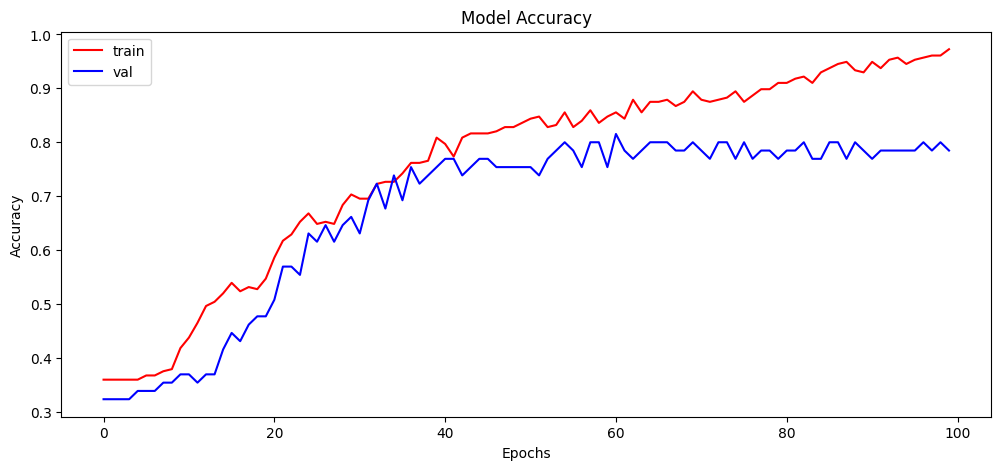

In [ ]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Here we analyse how the model is learning with each epoch in terms of accuracy.

In [ ]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 3s 336ms/step - loss: 3.1675 - accuracy: 0.6389
Accuracy over the test set: 
  63.89 %


We will use predict function to make predictions using this model also we are finding out the accuracy on the test set.

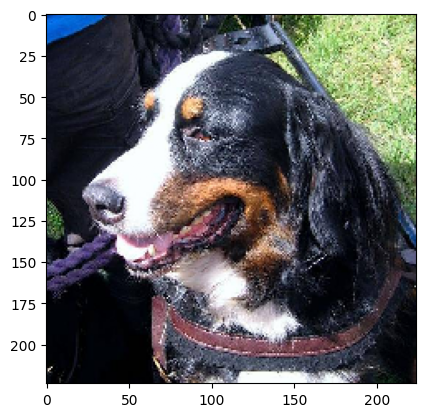

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [ ]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

In [ ]:
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices.
import pandas as pd # A common package for viewing tabular data
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
import os # we use this to oad things from the local file system
from sklearn.model_selection import train_test_split # A library that can automatically perform data splitting for us
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score # Various classification metrics we may find useful

import tensorflow as tf # loads all of tensorflow. This gives us access to everything, but we need to call the correct library
from tensorflow import keras # karas is a hgiher level library built on tensorflow. Most of what we are doing is actually using keras.
from tensorflow.keras import layers, datasets # Import the different model layers and datasets
import tensorflow_datasets as tfds # An alternate way to load tensorflow datasets
from tensorflow.keras.preprocessing.image import load_img, img_to_array # Some tensofrlow preprocessing librarie we need to load in local image files
from keras.models import Model # We'll be using the functional/graphical api for our CNNs
%matplotlib inline

Epoch 1/10
8/8 [==============================] - 33s 4s/step - loss: 1.9110 - accuracy: 0.3359 - val_loss: 1.0773 - val_accuracy: 0.3281
Epoch 2/10
8/8 [==============================] - 31s 4s/step - loss: 1.0857 - accuracy: 0.4531 - val_loss: 1.0659 - val_accuracy: 0.3750
Epoch 3/10
8/8 [==============================] - 31s 4s/step - loss: 1.0579 - accuracy: 0.4453 - val_loss: 0.9946 - val_accuracy: 0.5938
Epoch 4/10
8/8 [==============================] - 36s 5s/step - loss: 1.0322 - accuracy: 0.4766 - val_loss: 0.9017 - val_accuracy: 0.5938
Epoch 5/10
8/8 [==============================] - 32s 4s/step - loss: 0.9513 - accuracy: 0.5781 - val_loss: 0.8157 - val_accuracy: 0.7656
Epoch 6/10
8/8 [==============================] - 30s 4s/step - loss: 0.8892 - accuracy: 0.6055 - val_loss: 0.7778 - val_accuracy: 0.7344
Epoch 7/10
8/8 [==============================] - 32s 4s/step - loss: 0.9233 - accuracy: 0.5625 - val_loss: 0.7237 - val_accuracy: 0.7500
Epoch 8/10
8/8 [==================

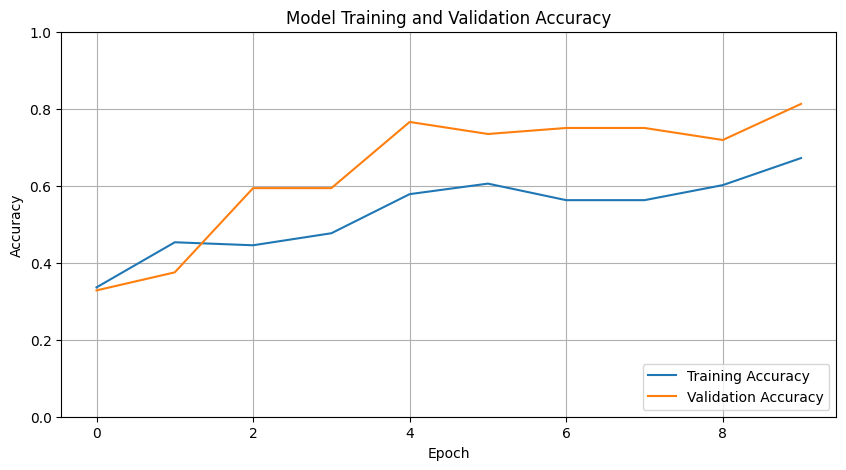

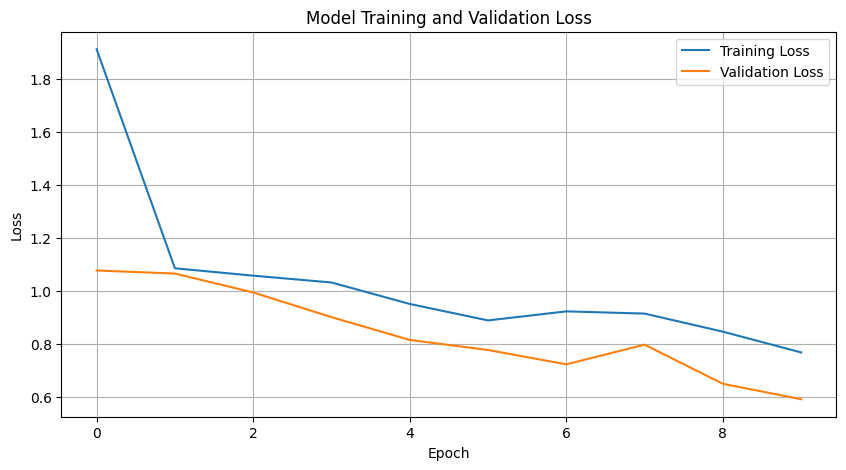

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator()

# Prepare generators
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
validation_generator = validation_datagen.flow(X_val, Y_val, batch_size=32)

# Define the CNN model using Keras Functional API
num_classes = Y_data.shape[1]  # Number of unique classes
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Softmax for multiclass
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(X_val) // 32
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator, steps=len(X_val) // 32)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=32)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Plot training history
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       7385

In [ ]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 2s 193ms/step - loss: 0.5010 - accuracy: 0.8611
Accuracy over the test set: 
  86.11 %


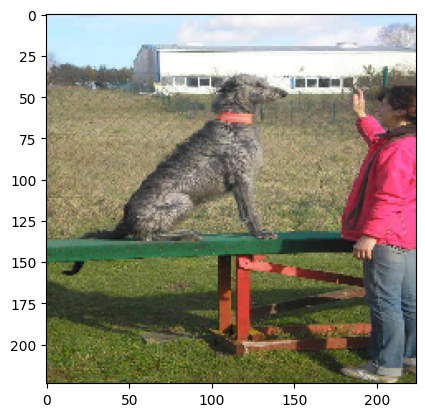

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [ ]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

Here you can see image with its original and predicted label.

## Conclusion:

We started with downloading the dataset creating the model and finding out the predictions using the model. We can optimize different hyper parameters in order to tune this model for a higher accuracy. This model can be used to predict different breeds of dogs which can be further used by different NGO's working on saving animals and for educational purposes also.

In [ ]:
model.save("dog_breed.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
